# Task

The [task](https://www.kaggle.com/competitions/advanced-dls-spring-2021/overview) is to predict churn of telecom company customers.  
This task is very important in practice and algorithms for solving it are used in real telecom companies, because if we know that the client is going to leave us, then we will try to keep him by offering some bonuses.

# Imports

In [1]:
import os
import sys
import warnings

import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from catboost import CatBoostClassifier, Pool, cv, metrics
from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.exceptions import ConvergenceWarning
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler, StandardScaler

optuna.logging.set_verbosity(optuna.logging.WARNING)
sns.set(rc={"figure.dpi": 100, "savefig.dpi": 300})
sns.set_context("notebook")
sns.set_style("ticks")

ConvergenceWarning("ignore")

warnings.filterwarnings("ignore")
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore::UserWarning,ignore::ConvergenceWarning,ignore::RuntimeWarning"
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
SEED = 42

# Metric

In this case, we will use ROC-AUC. It can be calculated using only predicted probabilities and true classes without a specific classification threshold + it works even if the classes are highly unbalanced (there are dozens of times more examples of one class than examples of another). That is why it is very convenient for competitions.

It is easy to calculate it:

In [3]:
y_true = [0, 1, 1, 0, 1]
y_predictions = [0.1, 0.9, 0.4, 0.6, 0.61]

roc_auc_score(y_true, y_predictions)

0.8333333333333333

# Loading Data

In [4]:
data = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")

## Setting Columns

This dataset contains numerical and categorical columns, which are listed below:

In [5]:
num_cols = ["ClientPeriod", "MonthlySpending", "TotalSpent"]

cat_cols = [
    "Sex",
    "IsSeniorCitizen",
    "HasPartner",
    "HasChild",
    "HasPhoneService",
    "HasMultiplePhoneNumbers",
    "HasInternetService",
    "HasOnlineSecurityService",
    "HasOnlineBackup",
    "HasDeviceProtection",
    "HasTechSupportAccess",
    "HasOnlineTV",
    "HasMovieSubscription",
    "HasContractPhone",
    "IsBillingPaperless",
    "PaymentMethod",
]

feature_cols = num_cols + cat_cols
target_col = "Churn"

## Dataset Overview

This can be done using the `df.sample(n=10, random_state=SEED)` method, specifying the number of lines `n` and `random_state` (for reproducible calculations).  
I looked at 30 random lines, but left 10 in the code for easier viewing. Missing values are not visually visible - we will check this formally in the next section.  
You can also look at the beginning and end of the dataset using the `df.head(n=10)` and `df.tail(n=10)` methods, respectively.

In [6]:
data.sample(n=10, random_state=SEED)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1448,9,45.40,418.8,Male,0,No,No,No,No phone service,DSL,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,1
4792,37,70.35,2552.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,0
8,50,105.95,5341.8,Male,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,No,Yes,No,Yes,Yes,Month-to-month,No,Credit card (automatic),1
3964,44,100.10,4378.35,Male,0,No,No,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Two year,No,Bank transfer (automatic),0
240,25,20.95,495.15,Male,0,Yes,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Bank transfer (automatic),0
1942,39,50.75,2011.4,Female,0,No,No,No,No phone service,DSL,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,1
1859,52,79.20,4016.3,Male,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Electronic check,0
2348,1,74.40,74.4,Male,1,Yes,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,1
2280,6,50.80,288.05,Female,0,No,No,Yes,No,DSL,No,No,No,Yes,No,No,Month-to-month,Yes,Bank transfer (automatic),1
733,21,68.65,1493.2,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,0


## Dataset Close Look

In this section, let's look at what columns we have, what type they are, how many non-zero values, etc.

In [7]:
data.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

(None, None)

In total, we have `5282` lines in the sample for training. In the test sample `1761` object. There are no missing values. Let's confirm this again.  
This can be done with the `.isna()` or `.isnull()` methods - as far as I understand they are equivalent.  
`data.isnull()` gives `True` for each value if it is omitted and `False` otherwise.  
`data.isnull().any()` shows whether there are missing values in columns (aggregated).  
`data.isnull().values.any()` generalizes missing value resolution to the entire dataset.  

In [8]:
assert data.isnull().values.any() == False

There are no really missing values, but we know that the `TotalSpent` column contains numeric values, and in the data it is a string columns - let's look at it.

In [9]:
data["TotalSpent"].value_counts()

           9
20.2       9
19.75      8
20.05      6
19.65      6
          ..
41.85      1
4326.25    1
950.2      1
4264       1
1375.6     1
Name: TotalSpent, Length: 4978, dtype: int64

We see that an empty string is there 9 times in the data. Let's check it out.

In [10]:
data[data["TotalSpent"] == " "]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0,25.75,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,0,73.35,,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,0,19.70,,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,0,80.85,,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3697,0,20.00,,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,0,61.90,,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4326,0,25.35,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4551,0,52.55,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4598,0,56.05,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


It is true. Let's replace empty strings with `NaN` throughout the dataset. And change the column type `TotalSpent` to `float`.

In [11]:
data.replace(r"^\s*$", np.nan, regex=True, inplace=True)
data["TotalSpent"] = data["TotalSpent"].astype("float")
data.isna().any(), data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5273 non-null   float64
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

(ClientPeriod                False
 MonthlySpending             False
 TotalSpent                   True
 Sex                         False
 IsSeniorCitizen             False
 HasPartner                  False
 HasChild                    False
 HasPhoneService             False
 HasMultiplePhoneNumbers     False
 HasInternetService          False
 HasOnlineSecurityService    False
 HasOnlineBackup             False
 HasDeviceProtection         False
 HasTechSupportAccess        False
 HasOnlineTV                 False
 HasMovieSubscription        False
 HasContractPhone            False
 IsBillingPaperless          False
 PaymentMethod               False
 Churn                       False
 dtype: bool,
 None)

Let's do the same for the test dataset, since there are also missing values in this column.  
And in general, we will check if there are still empty lines in the dataset

In [12]:
print(f"In test dataset in column 'TotalSpent' there are {test['TotalSpent'].value_counts()[' ']} empty values\n")
test.replace(r"^\s*$", np.nan, regex=True, inplace=True)
test["TotalSpent"] = test["TotalSpent"].astype("float")
test.isna().any(), test.info()

In test dataset in column 'TotalSpent' there are 2 empty values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              1761 non-null   int64  
 1   MonthlySpending           1761 non-null   float64
 2   TotalSpent                1759 non-null   float64
 3   Sex                       1761 non-null   object 
 4   IsSeniorCitizen           1761 non-null   int64  
 5   HasPartner                1761 non-null   object 
 6   HasChild                  1761 non-null   object 
 7   HasPhoneService           1761 non-null   object 
 8   HasMultiplePhoneNumbers   1761 non-null   object 
 9   HasInternetService        1761 non-null   object 
 10  HasOnlineSecurityService  1761 non-null   object 
 11  HasOnlineBackup           1761 non-null   object 
 12  HasDeviceProtection       1761 non-null   object 
 13

(ClientPeriod                False
 MonthlySpending             False
 TotalSpent                   True
 Sex                         False
 IsSeniorCitizen             False
 HasPartner                  False
 HasChild                    False
 HasPhoneService             False
 HasMultiplePhoneNumbers     False
 HasInternetService          False
 HasOnlineSecurityService    False
 HasOnlineBackup             False
 HasDeviceProtection         False
 HasTechSupportAccess        False
 HasOnlineTV                 False
 HasMovieSubscription        False
 HasContractPhone            False
 IsBillingPaperless          False
 PaymentMethod               False
 dtype: bool,
 None)

## Results

As a result, for now, let's try not to get rid of missing values (and then we'll see), because there are few of them and gradient boosting, such as XGBoost or LightGBM, can automatically handle them.

In this section, we looked at our dataset, noticed that the `TotalSpent` column was of the wrong type and had missing values as an empty string, and fixed it.

# Data Analysis

### Numerical features

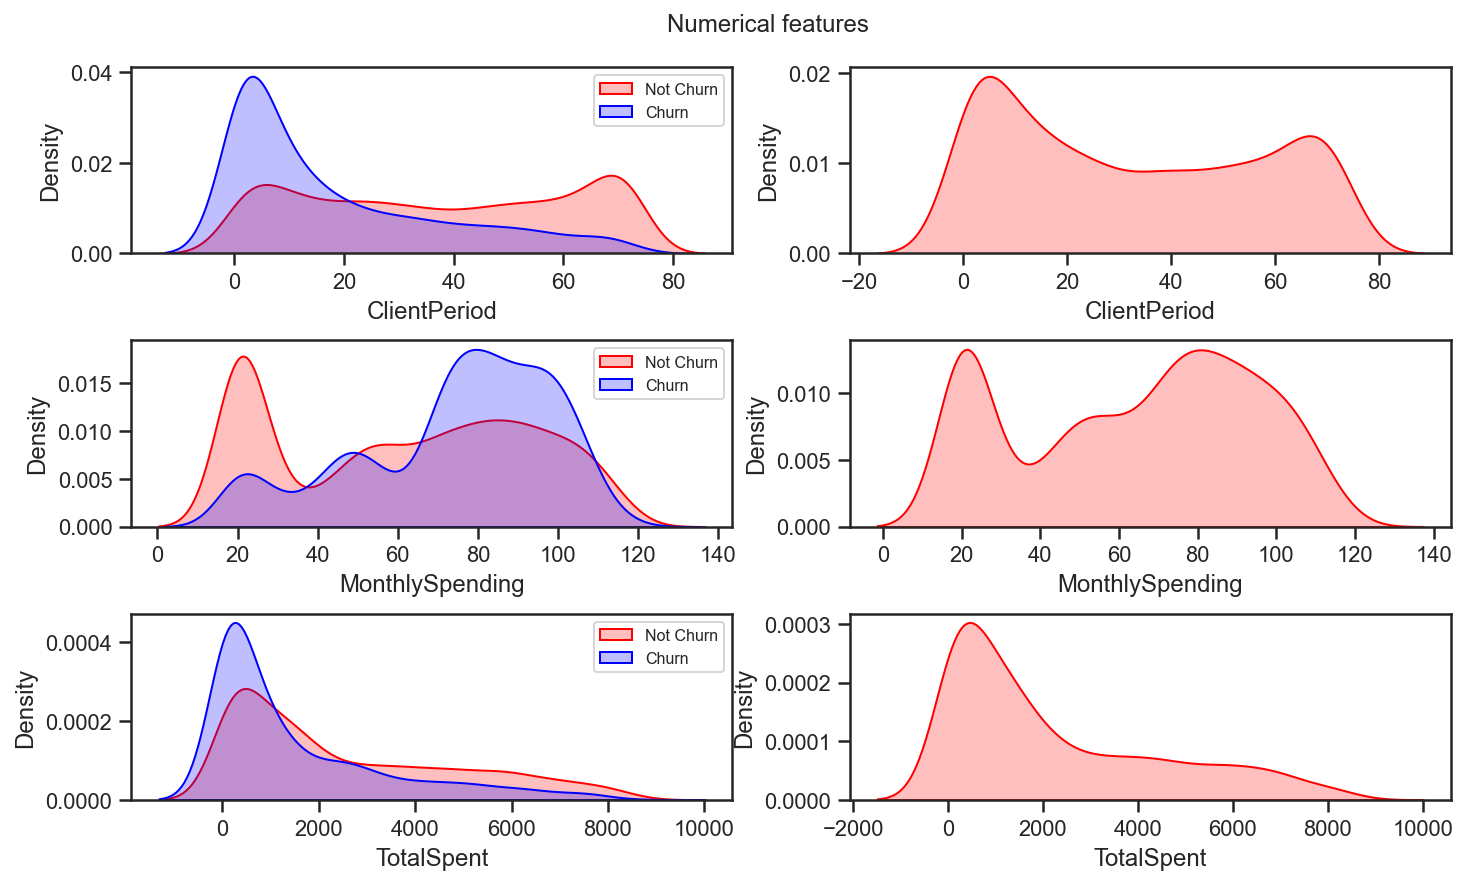

In [13]:
fig, axs = plt.subplots(
    nrows=len(num_cols), ncols=2, figsize=(10, 6)
)  # Инициализируем 3 подграфика с определенным размером
fig.suptitle("Numerical features")  # Общее название для группы графиков
fig.tight_layout(h_pad=2, w_pad=2)  # для того, чтобы графики не стояли слишком близко друг к другу

for i, num_feature in enumerate(num_cols):
    g1 = sns.kdeplot(data[data[target_col] == 0][num_feature], ax=axs[i, 0], color="red", shade=True)
    g1 = sns.kdeplot(data[data[target_col] == 1][num_feature], ax=axs[i, 0], color="blue", shade=True)
    g1.legend(["Not Churn", "Churn"], fontsize=8)

    g2 = sns.kdeplot(test[num_feature], ax=axs[i, 1], color="red", shade=True)

As an analogue of the histogram, you can use the [KDE graph](https://en.wikipedia.org/wiki/Kernel_density_estimation) - it makes it easier to visualize and interpret the data.

**1 column**
I added 2 subplots to each plot for a numeric feature: one uses data that has churn == 0, the other uses data for churn == 1. This helps to see the difference in how the data is distributed and suggests how useful the feature will be for predicting the target variable .

*It can be seen that for the first two features there are significant differences in how the data is distributed for different classes. Yes, and in the third there are differences, but not so significant.*

**2 column**
Added data distribution in the test sample to see if there are any significant differences between the training and test data (there are none).

### Categorical features

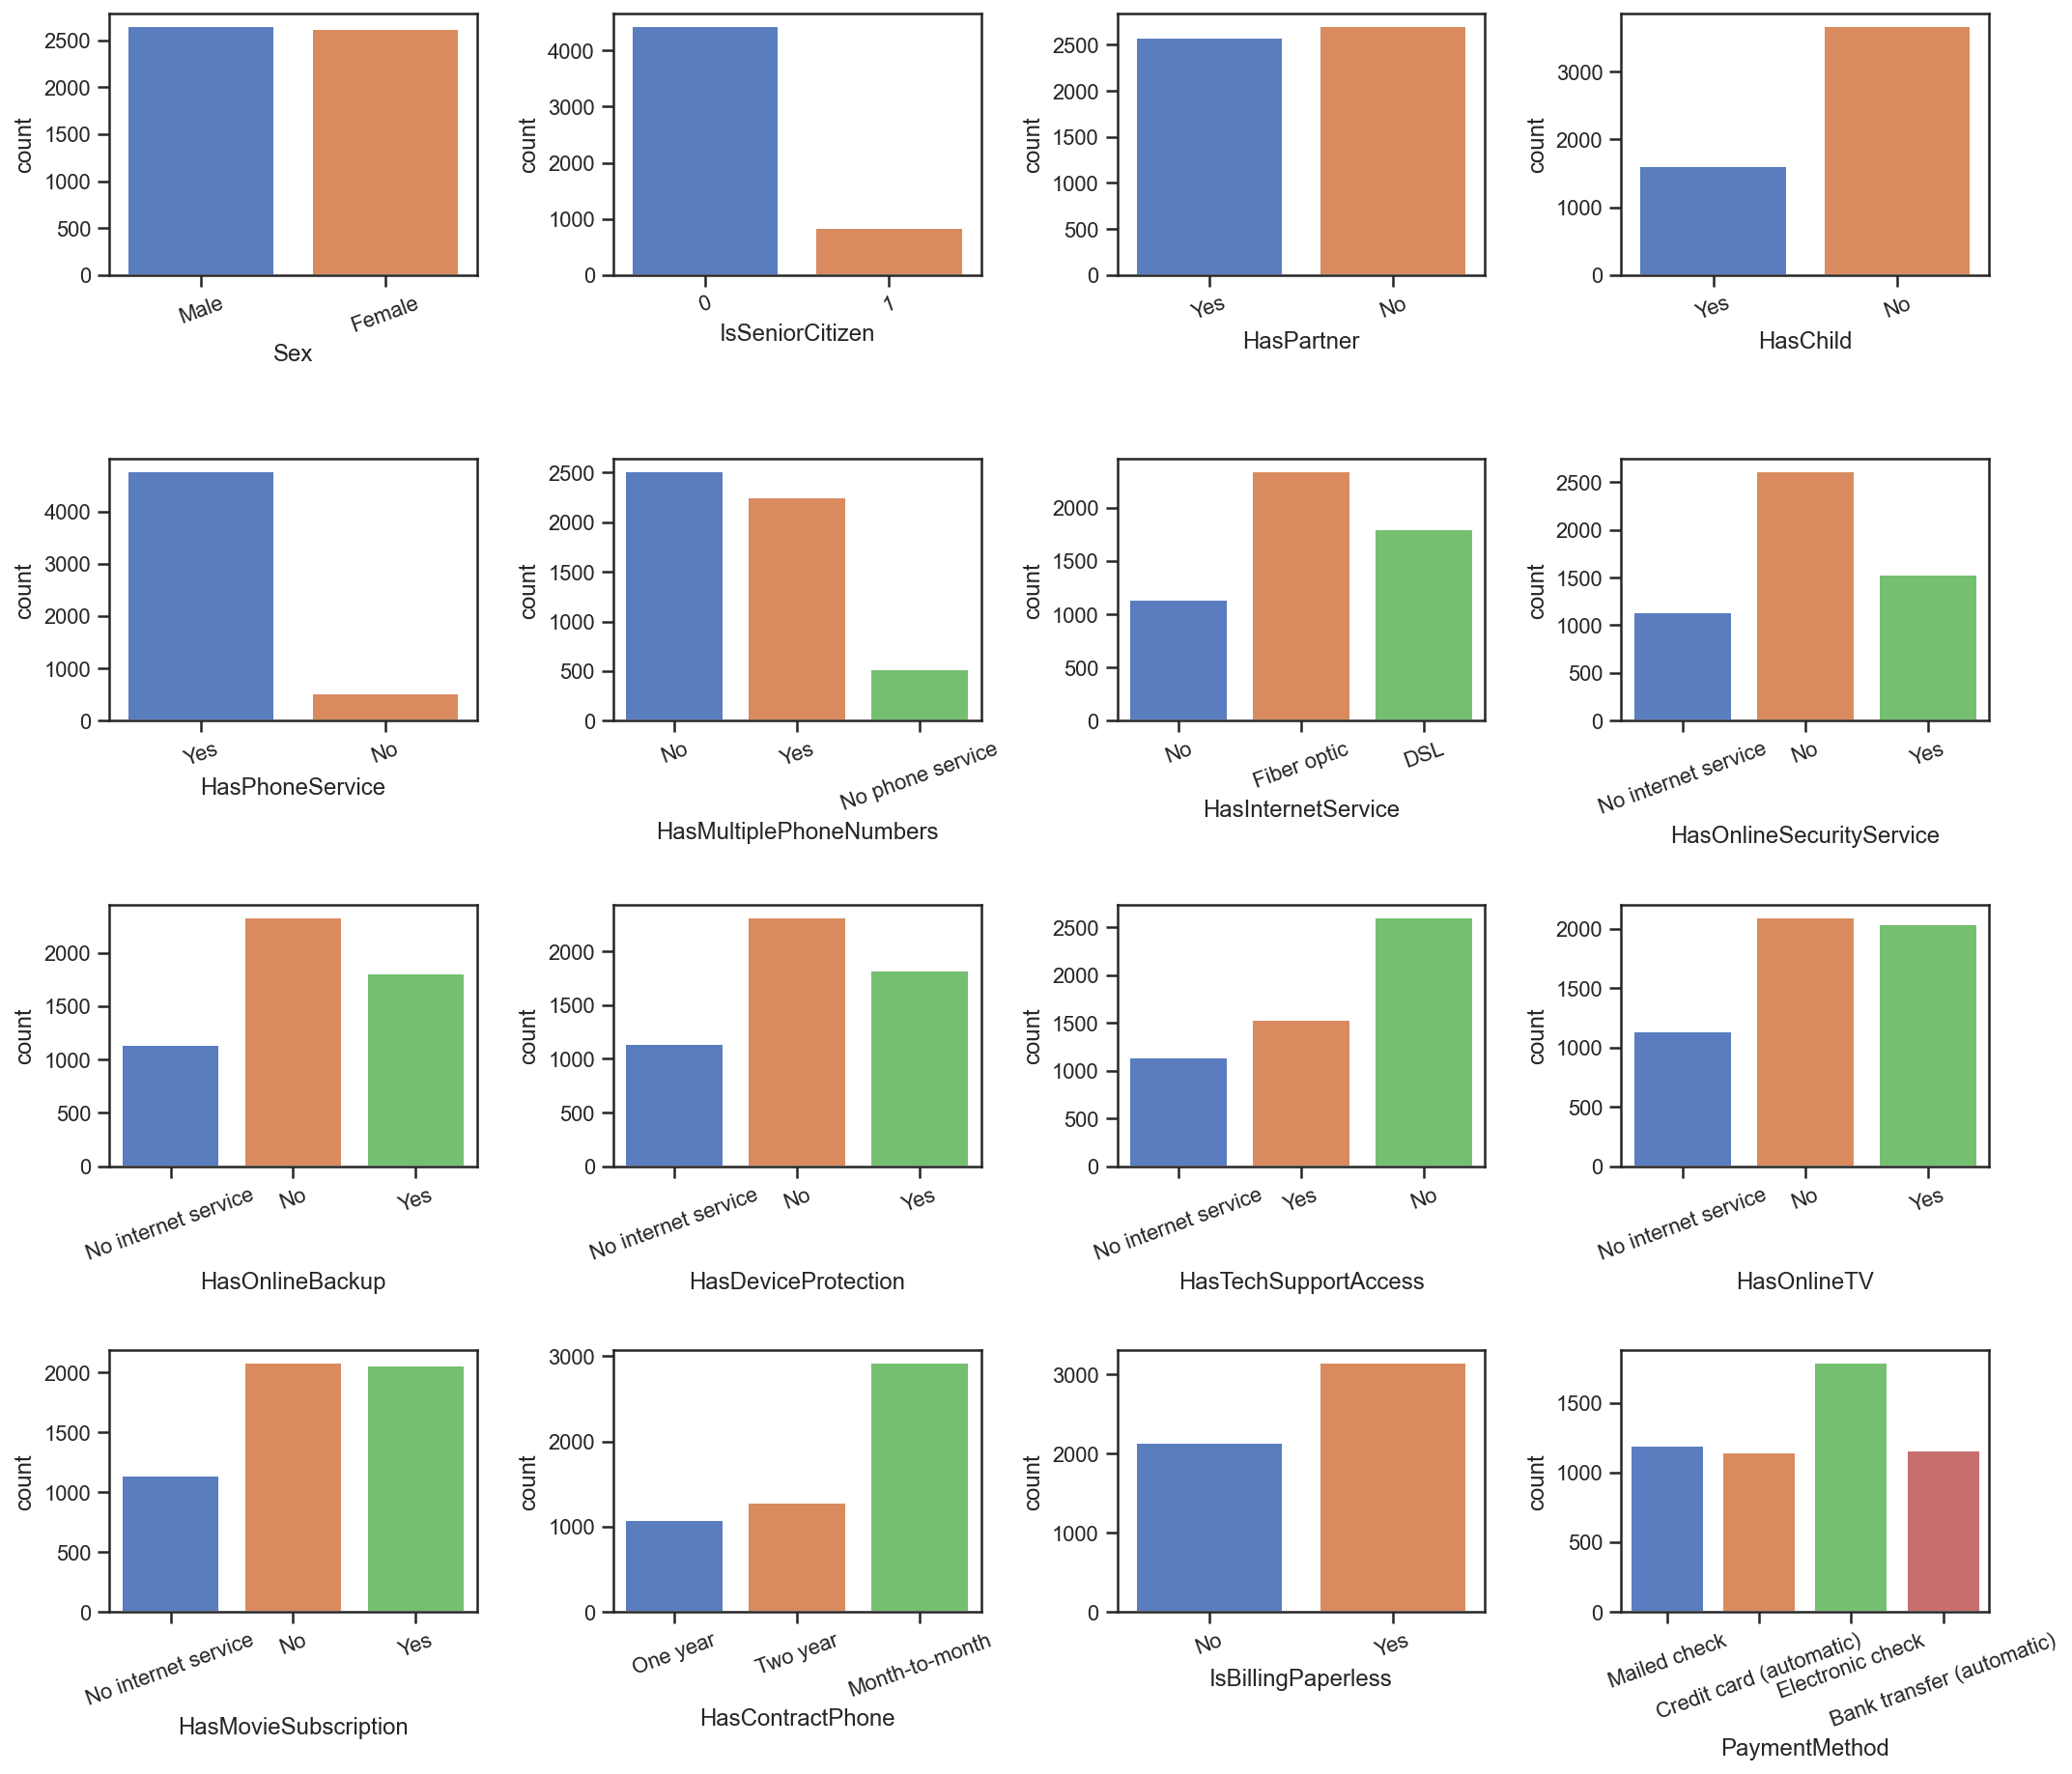

In [14]:
col_nums = 4
row_nums = len(cat_cols) // col_nums + 1
plt.figure(figsize=(15, 15))

for i, cat_feature in enumerate(cat_cols):
    plt.subplot(row_nums, col_nums, i + 1)
    g = sns.countplot(x=cat_feature, data=data, palette="muted")
    plt.xticks(rotation=20)

plt.tight_layout(h_pad=2)
plt.show()

### Target variable

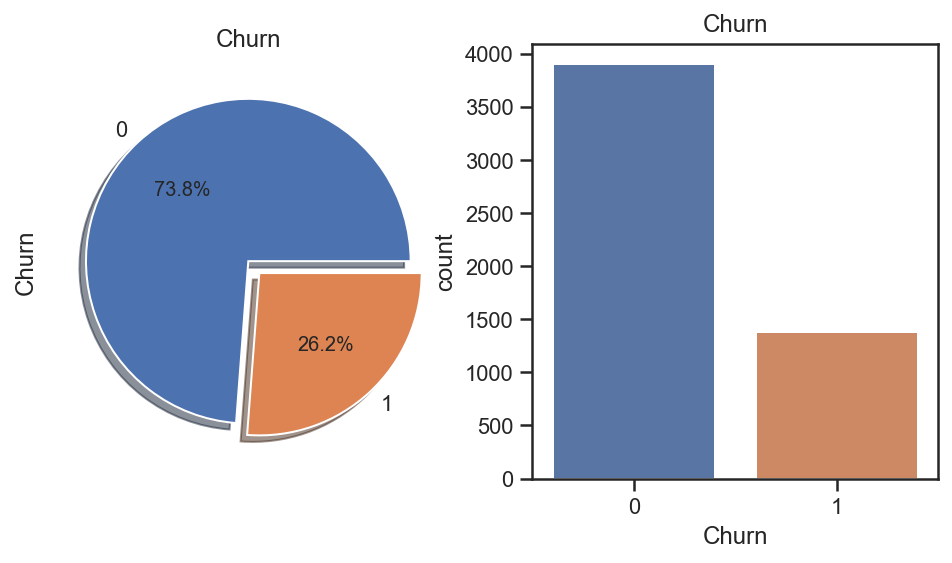

In [15]:
f, ax = plt.subplots(1, 2, figsize=(8, 4))
data[target_col].value_counts().plot.pie(explode=[0, 0.1], autopct="%1.1f%%", ax=ax[0], shadow=True)
ax[0].set_title(target_col)
ax[0].set_ylabel(target_col)
sns.countplot(x=target_col, data=data, ax=ax[1])
ax[1].set_title(target_col)
plt.show()

We have strong class disbalance, therefore:
 - In training we'll use [Stratified k-fold](https://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold) as a CV approach
 - We cannot use [Accuracy](https://ml-handbook.ru/chapters/model_evaluation/intro#%D0%B1%D0%B8%D0%BD%D0%B0%D1%80%D0%BD%D0%B0%D1%8F-%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F-%D0%BC%D0%B5%D1%82%D0%BA%D0%B8-%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%BE%D0%B2) as a metric

### Categorical features vs Target

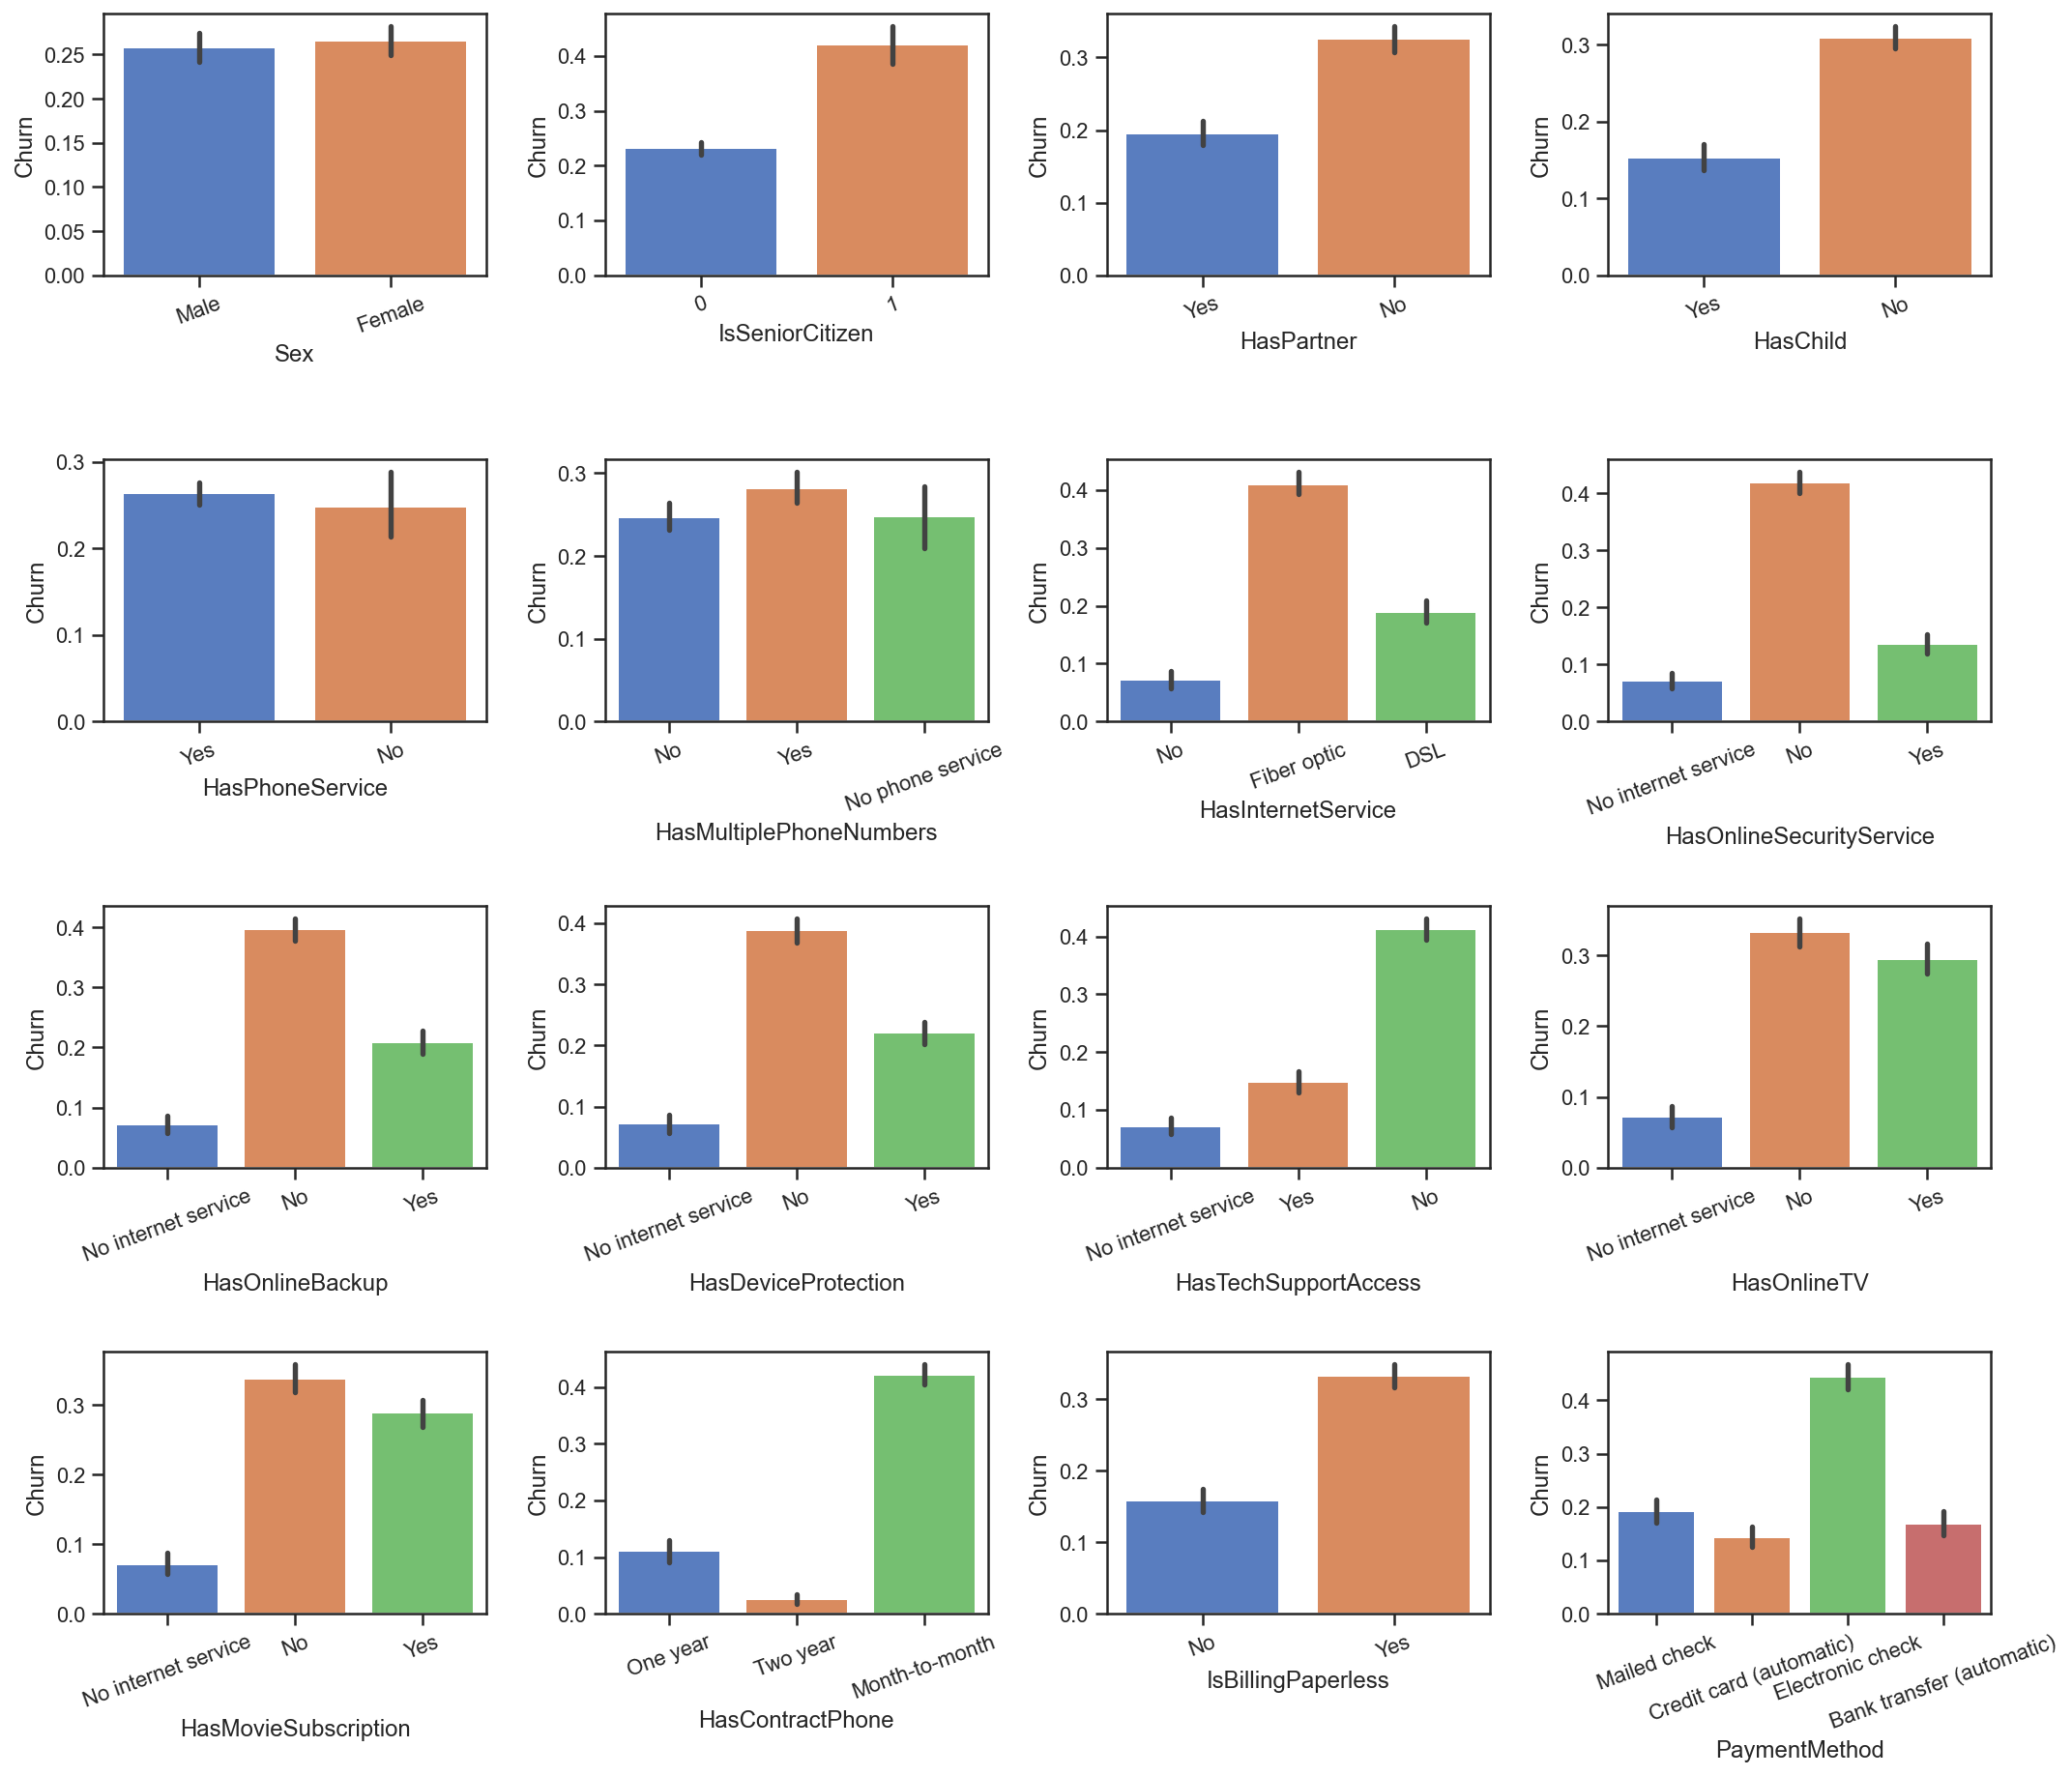

In [16]:
col_nums = 4
row_nums = len(cat_cols) // col_nums + 1
plt.figure(figsize=(15, 15))

for i, cat_feature in enumerate(cat_cols):
    plt.subplot(row_nums, col_nums, i + 1)
    g = sns.barplot(x=cat_feature, y=target_col, data=data, palette="muted")
    plt.xticks(rotation=20)

plt.tight_layout(h_pad=2)
plt.show()

### Duplicates

In [17]:
data.shape, data.drop_duplicates().shape

((5282, 20), (5268, 20))

We can see that we have duplicates.  
Let's remove them

In [18]:
data.drop_duplicates(inplace=True)
assert data.shape == data.drop_duplicates().shape

### Outliers

TODO

# Modelling

## Linear models

**Pipeline**

  - Preprocessing:
      - For categorical data:
          - Encode them with one-hot-encoding
      - For numeric data:
          - Fill in the gaps in the data (since logistic regression will not be able to work on such data, and feature scaling will not work)
          - Scale the features to get a mean of 0 and a standard deviation of 1
  - Trainng  
  Doing cross-validation and searching for the best hyperparameters at the same time

In [19]:
numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer()), ("scaler", StandardScaler())])
categorical_transformer = OneHotEncoder(handle_unknown="ignore")
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(max_iter=1000, random_state=42)),
    ]
)

param_grid = {
    "preprocessor__num__imputer__strategy": ["mean", "median"],
    "classifier__C": np.logspace(-2, 2, 100),
}

grid_search = GridSearchCV(clf, param_grid, cv=5, scoring="roc_auc", n_jobs=-1, verbose=2)

Let's prepare data for training

In [20]:
X = data.drop("Churn", axis=1)
y = data["Churn"]

Training

In [21]:
grid_search.fit(X, y)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['ClientPeriod',
                                                                          'MonthlySpending',
                                                                          'TotalSpent']),
                                                                        ('cat',
                                                                        

The best ROC-AUC value

In [22]:
grid_search.best_score_.round(6)

0.844534

The best hyperparameters

In [23]:
grid_search.best_params_

{'classifier__C': 52.140082879996896,
 'preprocessor__num__imputer__strategy': 'median'}

Leaderboard result: **0.84578**

## Gradient Boosting

### Catboost with default hyperparameters


Catboost with default hyperparams can give us one of the best baselines for tabular tasks

In [24]:
X_train, X_valid, y_train, y_valid = train_test_split(data.drop("Churn", axis=1), data["Churn"], test_size=0.2)

In [25]:
params = {
    "eval_metric": metrics.AUC(),
    "random_seed": 42,
    "logging_level": "Silent",
    "use_best_model": True,
}
train_pool = Pool(X_train, y_train, cat_features=cat_cols)
validate_pool = Pool(X_valid, y_valid, cat_features=cat_cols)

In [26]:
model = CatBoostClassifier(**params)

In [27]:
model.fit(train_pool, eval_set=validate_pool);

In [28]:
predictions_probs = model.predict_proba(test)[:, 1]

Leaderboard result: **0.84865**

We can already see a bit of a gain comparing with tuned Logistic Regression.  
We even:
* Didn't impute missing values
* Didn't scale data
* Didn't encode categorical columns (by hands)

### Hyperparameter search for CatBoost Classifier using Optuna

#### First step

To begin with, we'll fix the number of trees to `20` (it should not be very large for the algorithm to learn quickly), tuning the remaining hyperparameters. Won't tune learning rate - CatBoost will choose it for us.

Then, when constructing the final algorithm, we will increase the number of trees and find the corresponding value of the rate (leaving the rest of the parameters unchanged).

In [29]:
def objective(trial):

    global train_pool

    param = {
        "random_state": 42,
        "eval_metric": "AUC",
        "loss_function": "Logloss",
        "auto_class_weights": "Balanced",
        "logging_level": "Silent",
        "n_estimators": 20,
        "grow_policy": trial.suggest_categorical("grow_policy", ["Lossguide", "SymmetricTree", "Depthwise"]),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 2.5, 4),
        "random_strength": trial.suggest_float("random_strength", 0.9, 1.4),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 5),
        "eta": trial.suggest_float("eta", 0.01, 0.3),
    }

    scores = cv(train_pool, param, fold_count=5)

    return scores["test-AUC-mean"].values[-1]

In [30]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1, timeout=600, n_jobs=-1)  # replace number of trials with number > 1

In [31]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

print("  Params: ")

for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 1
Best trial:
  Params: 
    grow_policy: Depthwise
    max_depth: 7
    subsample: 0.7881618168739487
    l2_leaf_reg: 3.0571847706461863
    random_strength: 1.3854614608019413
    min_data_in_leaf: 4
    eta: 0.10344236709893088


#### Second step

In [32]:
def objective(trial):

    global train_pool

    param = {
        "grow_policy": "Lossguide",
        "random_state": 42,
        "eval_metric": "AUC",
        "loss_function": "Logloss",
        "auto_class_weights": "Balanced",
        "logging_level": "Silent",
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
        "max_depth": 5,
        "subsample": 0.6345844481200155,
        "l2_leaf_reg": 3.517593235923729,
        "random_strength": 1.0156081716690806,
        "min_data_in_leaf": 3,
        "eta": 0.1634238665839478,
    }

    scores = cv(train_pool, param, fold_count=5)

    return scores["test-AUC-mean"].values[-1]

In [33]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1, timeout=600, n_jobs=-1)  # replace number of trials with number > 1

In [34]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

print("  Params: ")

for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 1
Best trial:
  Params: 
    n_estimators: 363


### Training final classifier

And now we will train the classifier with the best hyperparameters on the entire training dataset and test it on the test dataset

In [35]:
params = {
    "grow_policy": "Lossguide",
    "random_state": 42,
    "eval_metric": "AUC",
    "loss_function": "Logloss",
    "auto_class_weights": "Balanced",
    "logging_level": "Silent",
    "n_estimators": 97,
    "max_depth": 5,
    "subsample": 0.6345844481200155,
    "l2_leaf_reg": 3.517593235923729,
    "random_strength": 1.0156081716690806,
    "min_data_in_leaf": 3,
    "eta": 0.1634238665839478,
}

In [36]:
model_optimized = CatBoostClassifier(**params)

In [37]:
model_optimized.fit(data.drop("Churn", axis=1), data["Churn"], cat_features=cat_cols);

In [38]:
predictions_probs_optimized = model_optimized.predict_proba(test)[:, 1]

Leaderboard [result](https://www.kaggle.com/competitions/advanced-dls-spring-2021/leaderboard): **0.85552**  

And this result gives me the **15th place** out of 2,124 teams (currently)!

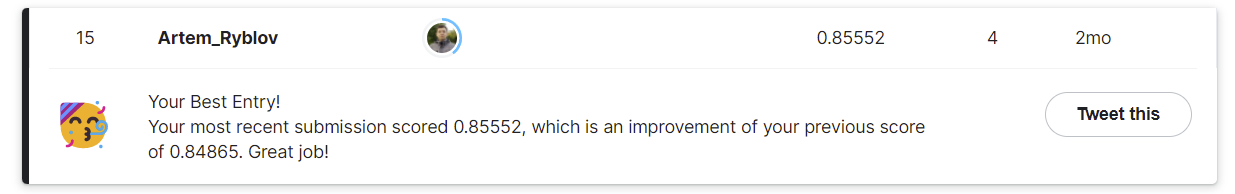

## Predictions

In [39]:
submission = pd.read_csv("./submission.csv")
submission["Churn"] = predictions_probs_optimized
submission.to_csv("./my_submission_catboost_optimized_best.csv", index=False)